## scANVI analysis for healthy PBMC pilot study (Cai 2020 and Cai 2022)

**Objective**: Run scANVI analysis for label transfer for healthy PBMCs [Cai 2020 and Cai 2022]


- **Developed by**: Mairi McClean

- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**

- v230317

- Following this tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html
> "This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query)."




- make amendments following atlas lung integration tutorial



In [1]:
# Sanity check
import os 
os.write(1, b"text\n")

text


5

### Import modules 

In [2]:
import sys
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi



Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [4]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'


Global seed set to 94705


### Read in data


- must use raw data; re-download because cellxgene is log-transformed

In [5]:
yoshida = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/INBOX/sc_downloads/yoshida_2021/meyer_nikolic_covid_pbmc.cellxgene.20210813.h5ad')

yoshida

AnnData object with n_obs × n_vars = 422220 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [6]:
yoshida.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.359517
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.577522
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Male,Non-smoker,AN3,CV001_KM10202384-CV001_KM10202394,0.369143
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.785563
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.564174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S28_TTTGTCAGTTCTGTTT-1,PC9,EUR,27.17,NK,NK,NK,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.429398
S28_TTTGTCATCAACCAAC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.677910
S28_TTTGTCATCATTATCC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.422796
S28_TTTGTCATCCTATGTT-1,PC9,EUR,27.17,DC,pDC,pDC,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.471905


In [7]:
yoshida.obs['COVID_status'].value_counts()

COVID_status
Healthy          173684
COVID-19         151312
Post-COVID-19     97224
Name: count, dtype: int64

In [8]:
reference = yoshida[yoshida.obs['COVID_status'] == 'Healthy']

reference

View of AnnData object with n_obs × n_vars = 173684 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [9]:
reference.obs['COVID_status'].value_counts()

COVID_status
Healthy    173684
Name: count, dtype: int64

In [10]:
# Note: Query data is that of only Cai, not the Cai+Yoshida data, but clustered following scvi. This is not the correct data object?

cai = sc.read_h5ad('/Volumes/LaCie/data_lake/Mairi_example/processed_files/abridged_qc/human/Cai2020_scRNA_PBMC_mm230315_qcd.h5ad')
cai

AnnData object with n_obs × n_vars = 73146 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [11]:
cai.obs

,study,individual,sample,tissue,donor,age,gender,status,data_type,centre,...,pct_counts_mt,total_counts_ribo,pct_counts_ribo,percent_mt2,n_counts,percent_chrY,XIST-counts,S_score,G2M_score,predicted_doublets
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAACAATC-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,6.017039,1676.0,29.747959,0.060170,5634.0,0.053248,0.0,-0.352188,-0.193287,0.0
AAACCTGAGAAGGTGA-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,1.668552,1901.0,53.761311,0.016686,3536.0,0.113122,0.0,-0.064944,-0.071169,0.0
AAACCTGAGATCTGCT-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,9.967497,367.0,19.880823,0.099675,1846.0,0.054171,0.0,-0.231399,-0.080643,0.0
AAACCTGAGCACAGGT-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,4.557977,772.0,19.333836,0.045580,3993.0,0.075131,0.0,-0.227884,-0.258770,0.0
AAACCTGAGCGTGAAC-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,2.457002,1003.0,49.287468,0.024570,2035.0,0.147420,0.0,0.020959,0.025030,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCGCGGTT-H1,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,3.250689,1904.0,52.451790,0.032507,3630.0,0.110193,0.0,-0.165353,-0.250572,0.0
TTTGTCAGTCGCTTCT-H1,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,4.287570,868.0,37.592033,0.042876,2309.0,0.043309,0.0,-0.177318,-0.173327,0.0
TTTGTCAGTTCGAATC-H1,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,6.650446,712.0,28.872669,0.066504,2466.0,0.040551,0.0,-0.235875,-0.013744,0.0


In [12]:
cai.obs['status'].value_counts()

status
active_TB    33104
Healthy      22049
latent_TB    17993
Name: count, dtype: int64

In [13]:
query = cai[cai.obs['status'] == 'Healthy']
query

View of AnnData object with n_obs × n_vars = 22049 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [14]:
query.obs['status'].value_counts()

status
Healthy    22049
Name: count, dtype: int64

In [15]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [16]:
X_is_raw(query)

False

In [17]:
X_is_raw(query)

False

In [18]:
reference.obs['seed_labels'] = reference.obs['annotation_broad'].copy()


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_2931/3136194272.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  reference.obs['seed_labels'] = reference.obs['annotation_broad'].copy()


In [19]:
query.obs['seed_labels'] = 'Unknown'

/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_2931/141644025.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  query.obs['seed_labels'] = 'Unknown'


- Concatenate both datasets


In [20]:
adata = reference.concatenate(query, batch_categories=['reference', 'query'], batch_key='dataset')

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [21]:
adata

AnnData object with n_obs × n_vars = 195733 × 22792
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'dataset'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference'

In [22]:
adata.X

<195733x22792 sparse matrix of type '<class 'numpy.float32'>'
	with 242201046 stored elements in Compressed Sparse Row format>

In [24]:
adata.obs['seed_labels'].value_counts()

seed_labels
T CD4+       49415
T CD8+       34110
Monocyte     28637
B            26132
Unknown      22049
NK           21871
T reg         3251
T g/d         3183
MAIT          2213
DC            2151
Cycling       1012
Platelets      626
HPC            416
Plasma         352
ILC            199
RBC            106
Baso/Eos        10
Name: count, dtype: int64

In [25]:
# Replace NaN values in patient ID column

adata.obs['patient_id'] = adata.obs['patient_id'].cat.add_categories("unknown").fillna("unknown")


### HVG selection

In [26]:
adata_raw = adata.copy()

In [27]:
# Added as initial hvg run gave error: "ValueError: cannot specify integer `bins` when input data contains infinity"

sc.pp.log1p(adata)
adata.layers['counts'] = adata.X.copy()
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 195733 × 22792
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'dataset'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference'
    uns: 'log1p'
    layers: 'counts'>

- Make reference and query objects from original adata object

In [28]:
query = np.array([s in ["query"] for s in adata.obs.dataset])

adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

- change to 5000

In [29]:
# We run highly variable gene selection on the reference data and use these same genes for the query data.

sc.pp.highly_variable_genes(adata_ref, n_top_genes=2000, layer="counts", batch_key="patient_id", subset=True)

adata_query = adata_query[:, adata_ref.var_names].copy()


In [31]:
adata_ref

AnnData object with n_obs × n_vars = 173684 × 2000
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'dataset'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
   

In [32]:
adata_query

AnnData object with n_obs × n_vars = 22049 × 2000
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'dataset'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference'
    uns: 'log1p'
    layers: 'counts'

### Train reference

> From tutorial: SCANVI tends to perform better in situations where it has been initialized using a pre-trained SCVI model. 

- scVI model

In [34]:
scvi.model.SCVI.setup_anndata(adata_ref, layer="counts", batch_key="patient_id")

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


- remove arches params, because this is scANVI + scARCHES

In [35]:
# Added for sarches params following tutorial; check if we require it?
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(adata_ref, **arches_params)
vae_ref.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/46:   0%|          | 0/46 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/46:   2%|▏         | 1/46 [00:25<19:04, 25.44s/it, loss=401, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/46: 100%|██████████| 46/46 [17:56<00:00, 23.19s/it, loss=357, v_num=1]

`Trainer.fit` stopped: `max_epochs=46` reached.


Epoch 46/46: 100%|██████████| 46/46 [17:56<00:00, 23.40s/it, loss=357, v_num=1]


In [36]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


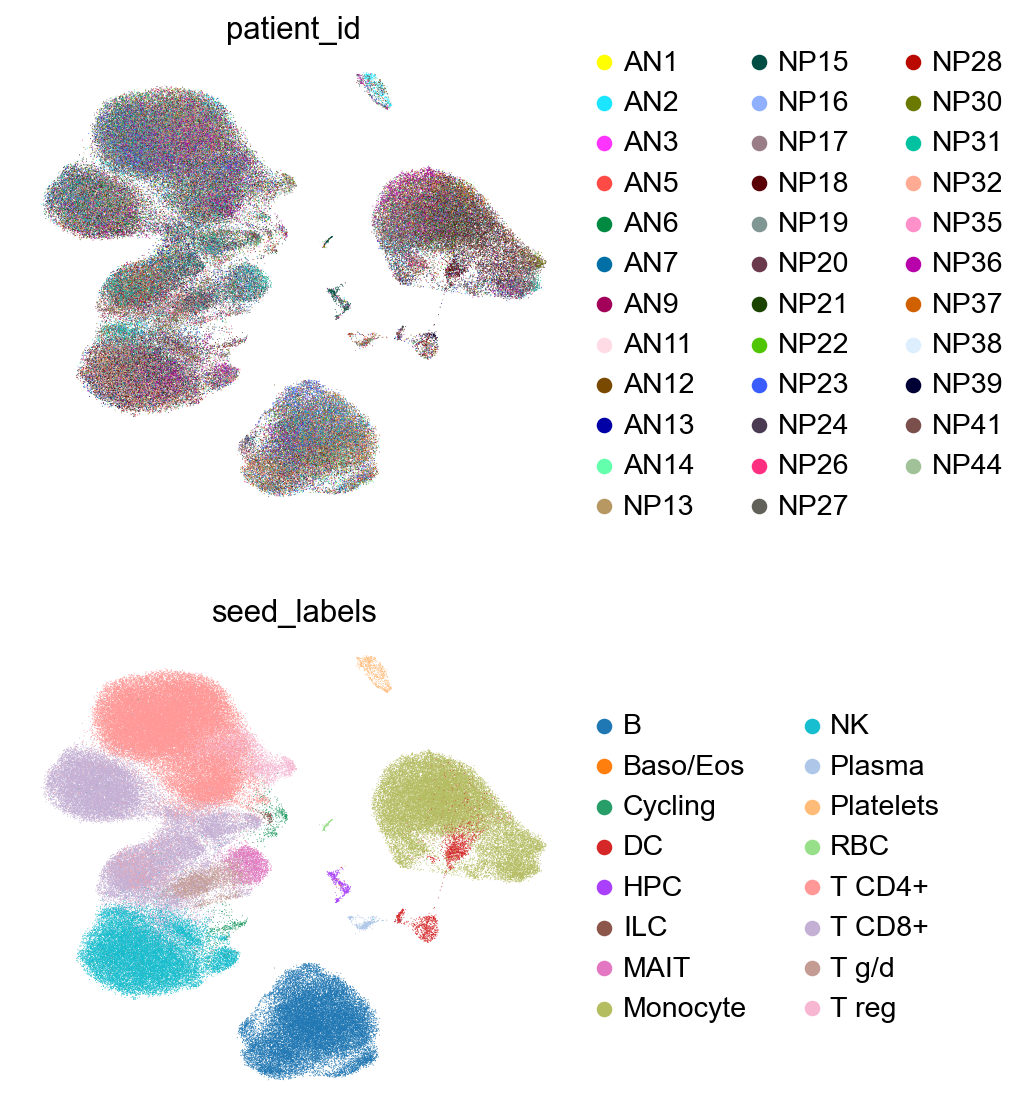

In [39]:
sc.pl.umap(
    adata_ref,
    color=["patient_id", "seed_labels"],
    frameon=False,
    ncols=1,
)

### Update with query

- scANVI model

In [40]:
adata_ref.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,...,n_counts,percent_chrY,XIST-counts,S_score,G2M_score,predicted_doublets,dataset,_scvi_batch,_scvi_labels,leiden
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1-reference,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,3,0,0
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1-reference,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,3,0,8
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1-reference,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,2,0,7
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1-reference,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,3,0,12
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1-reference,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,3,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22_TTTGTCAGTCGCATCG-1-reference,NP32,EUR,24.7,T CD8+,T CD8 naive,T CD8 naive,Adolescent,Healthy,Healthy,Paediatric,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,27,0,4
S22_TTTGTCAGTGTAAGTA-1-reference,NP32,EUR,24.7,NK,NK IFN stim,NK IFN stim,Adolescent,Healthy,Healthy,Paediatric,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,27,0,13
S22_TTTGTCATCATGTCCC-1-reference,NP31,AFR,18.2,Monocyte,Monocyte CD14,Classical monocyte,Child,Healthy,Healthy,Paediatric,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,26,0,0
S22_TTTGTCATCGAGGTAG-1-reference,NP31,AFR,18.2,T CD8+,T CD8 naive,T CD8 naive,Child,Healthy,Healthy,Paediatric,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,26,0,4


In [41]:
adata_ref.obs['seed_labels'].value_counts()

seed_labels
T CD4+       49415
T CD8+       34110
Monocyte     28637
B            26132
NK           21871
T reg         3251
T g/d         3183
MAIT          2213
DC            2151
Cycling       1012
Platelets      626
HPC            416
Plasma         352
ILC            199
RBC            106
Baso/Eos        10
Name: count, dtype: int64

In [53]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scanvi = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    unlabeled_category="Unknown",
    labels_key="seed_labels",
)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [54]:
vae_ref_scanvi.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/20:   5%|▌         | 1/20 [00:42<13:22, 42.25s/it, loss=450, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/20: 100%|██████████| 20/20 [13:43<00:00, 41.00s/it, loss=452, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [13:43<00:00, 41.18s/it, loss=452, v_num=1]


In [55]:
adata_ref.obsm["X_scANVI"] = vae_ref_scanvi.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)


/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


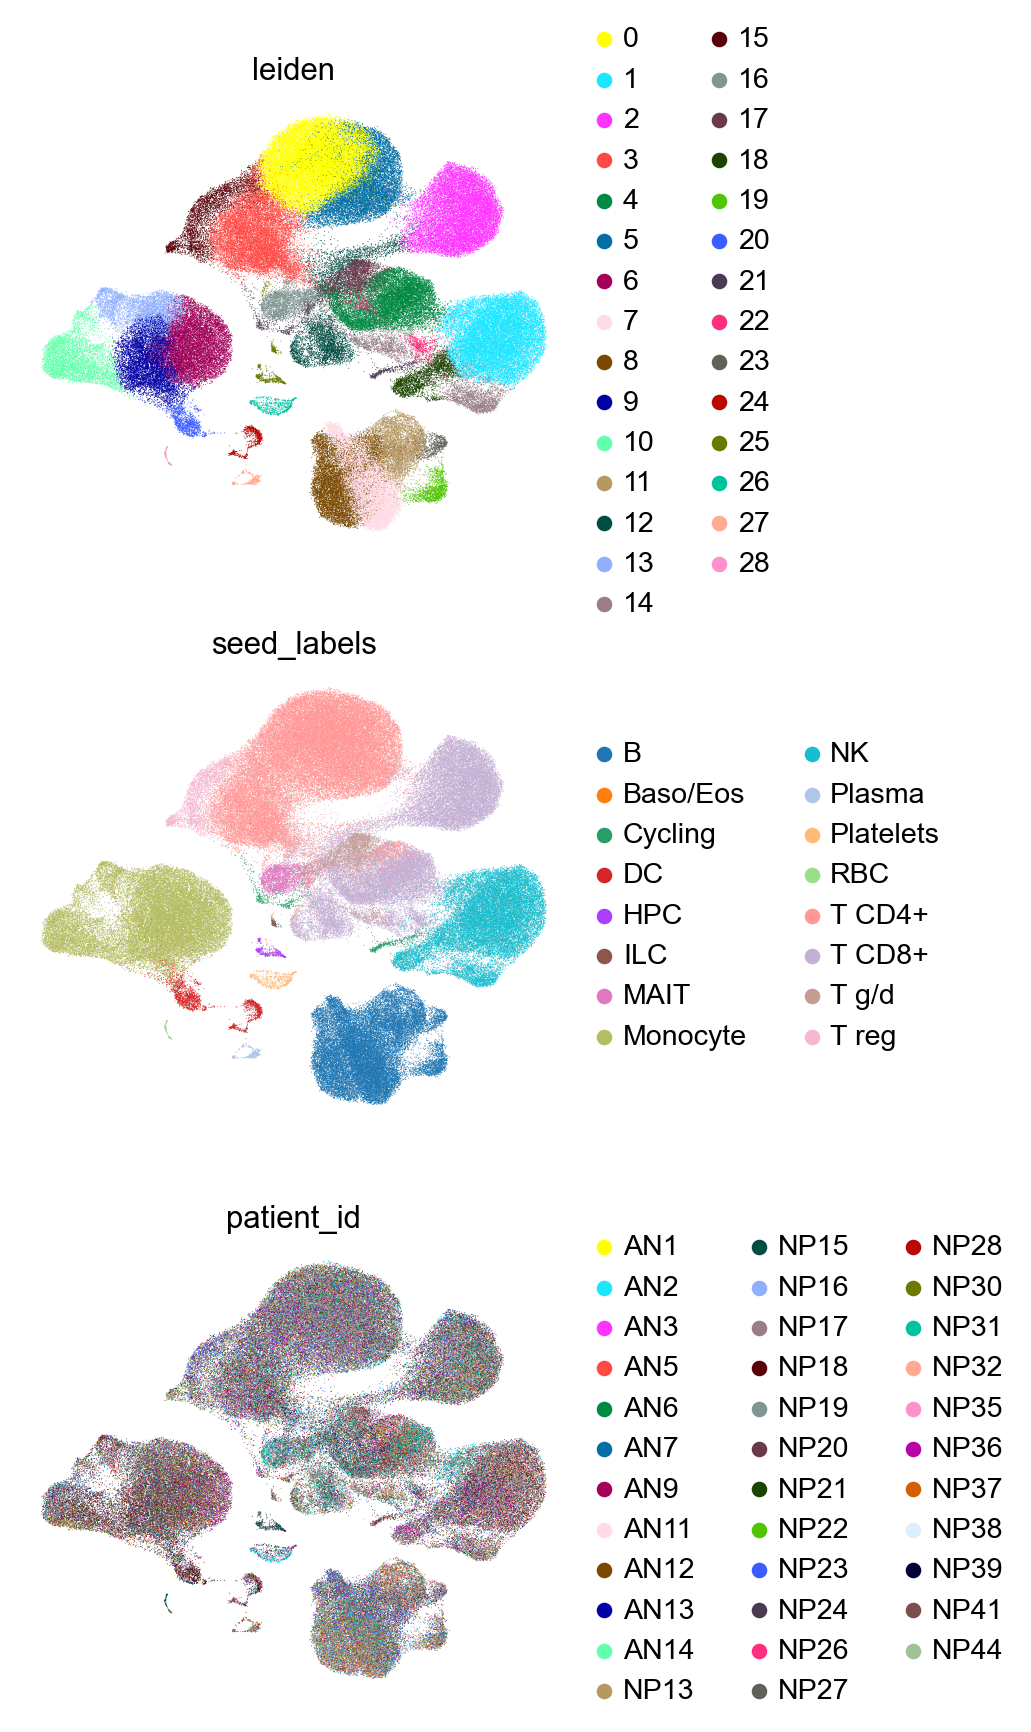

In [56]:
sc.pl.umap(
    adata_ref,
    color=["leiden", "seed_labels", "patient_id"],
    frameon=False,
    ncols=1,
)

### Update with query

In [57]:
dir_path_scan = "/Volumes/LaCie/data_lake/Mairi_example/processed_files/scanvi/models/"
vae_ref_scanvi.save(dir_path_scan, overwrite=True)


In [58]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(adata_query, dir_path_scan)

INFO     File /Volumes/LaCie/data_lake/Mairi_example/processed_files/scanvi/models/model.pt already downloaded     
INFO     Found 100.0% reference vars in query data.                                                                


In [59]:
vae_ref_scanvi.registry_

{'scvi_version': '0.20.3',
 'model_name': 'SCANVI',
 'setup_args': {'labels_key': 'seed_labels',
  'unlabeled_category': 'Unknown',
  'layer': 'counts',
  'batch_key': 'patient_id',
  'size_factor_key': None,
  'categorical_covariate_keys': None,
  'continuous_covariate_keys': None},
 'field_registries': defaultdict(dict,
             {'X': {'data_registry': {'attr_name': 'layers',
                'attr_key': 'counts'},
               'state_registry': {'n_obs': 173684,
                'n_vars': 2000,
                'column_names': array(['HES4', 'ISG15', 'TNFRSF18', ..., 'S100B', 'MT-CO1', 'MT-ND6'],
                      dtype=object)},
               'summary_stats': {'n_vars': 2000, 'n_cells': 173684}},
              'batch': {'data_registry': {'attr_name': 'obs',
                'attr_key': '_scvi_batch'},
               'state_registry': {'categorical_mapping': array(['AN1', 'AN2', 'AN3', 'AN5', 'AN6', 'AN7', 'AN9', 'AN11', 'AN12',
                       'AN13', 'AN14', 'NP13', 

In [60]:
adata_query.obs['seed_labels'].value_counts()

seed_labels
Unknown    22049
Name: count, dtype: int64

In [61]:
vae_query = scvi.model.SCANVI.load_query_data(
    adata_query,
    dir_path_scan,
)

INFO     File /Volumes/LaCie/data_lake/Mairi_example/processed_files/scanvi/models/model.pt already downloaded     


/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [62]:
vae_query.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/100:   1%|          | 1/100 [00:04<06:55,  4.20s/it, loss=627, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/100:  10%|█         | 10/100 [00:39<06:06,  4.07s/it, loss=601, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [06:29<00:00,  3.93s/it, loss=611, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [06:29<00:00,  3.89s/it, loss=611, v_num=1]


In [63]:
adata_query.obsm["X_scANVI"] = vae_query.get_latent_representation()
adata_query.obs["predictions"] = vae_query.predict()

In [71]:
adata_query.obs['predictions'].value_counts()

predictions
NK           4349
Monocyte     3814
T g/d        3102
T CD4+       2457
T reg        2122
T CD8+       2104
B            1584
MAIT          900
DC            621
ILC           398
Cycling       216
Plasma        180
Platelets     118
RBC            50
HPC            34
Name: count, dtype: int64

In [72]:
adata_query.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,...,n_counts,percent_chrY,XIST-counts,S_score,G2M_score,predicted_doublets,dataset,_scvi_batch,_scvi_labels,predictions
AAACCTGAGATGGCGT-H2-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2890.0,0.138408,0.0,-0.274516,-0.168208,0.0,query,35,16,T g/d
AAACCTGAGATGTGTA-H2-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3086.0,0.162022,0.0,-0.291798,-0.157942,0.0,query,35,16,T CD4+
AAACCTGAGCAACGGT-H2-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2861.0,0.174764,0.0,-0.315739,0.098983,0.0,query,35,16,T g/d
AAACCTGAGCCATCGC-H2-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6318.0,0.015828,0.0,0.037617,0.046320,0.0,query,35,16,Cycling
AAACCTGAGGTGATTA-H2-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1825.0,0.109589,0.0,0.001693,-0.202441,0.0,query,35,16,T g/d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCGCGGTT-H1-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3630.0,0.110193,0.0,-0.165353,-0.250572,0.0,query,35,16,T CD8+
TTTGTCAGTCGCTTCT-H1-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2309.0,0.043309,0.0,-0.177318,-0.173327,0.0,query,35,16,T g/d
TTTGTCAGTTCGAATC-H1-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2466.0,0.040551,0.0,-0.235875,-0.013744,0.0,query,35,16,Monocyte
TTTGTCAGTTTGGGCC-H1-query,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3273.0,0.091659,0.0,-0.050351,0.022269,0.0,query,35,16,T g/d


In [74]:
adata_ref.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 173684 × 2000
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'dataset', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_var

Text(0, 0.5, 'Observed')

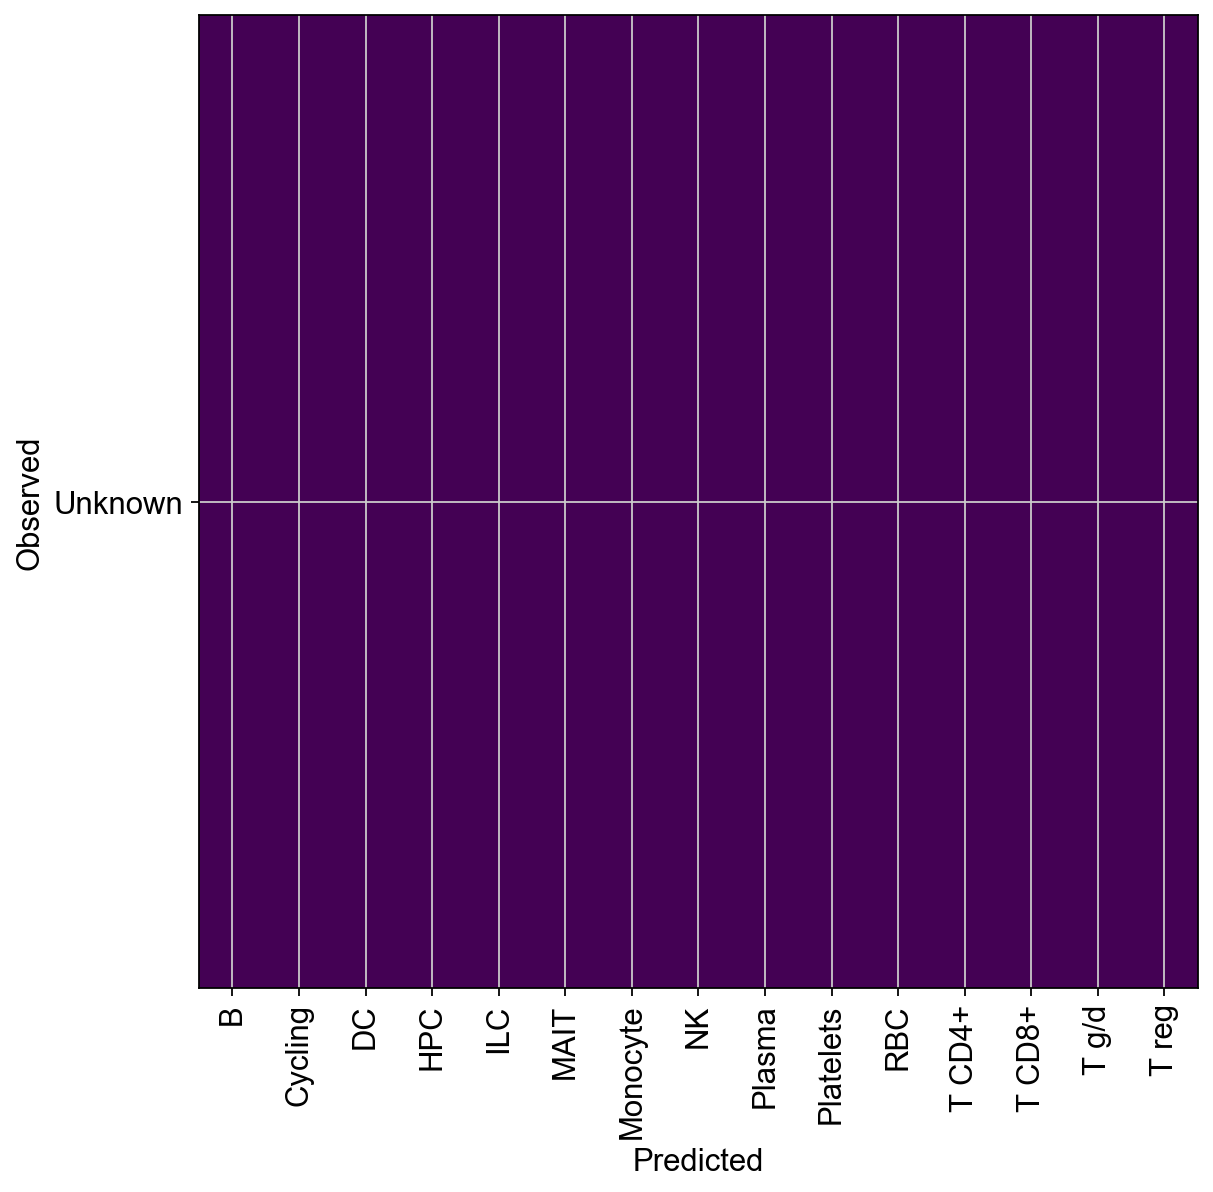

In [64]:
df = adata_query.obs.groupby(["seed_labels", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

### Analyze reference and query

In [65]:
adata_full = adata_query.concatenate(adata_ref)

In [66]:
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"])

AAACCTGAGATGGCGT-H2-query-0               Query
AAACCTGAGATGTGTA-H2-query-0               Query
AAACCTGAGCAACGGT-H2-query-0               Query
AAACCTGAGCCATCGC-H2-query-0               Query
AAACCTGAGGTGATTA-H2-query-0               Query
                                        ...    
S22_TTTGTCAGTCGCATCG-1-reference-1    Reference
S22_TTTGTCAGTGTAAGTA-1-reference-1    Reference
S22_TTTGTCATCATGTCCC-1-reference-1    Reference
S22_TTTGTCATCGAGGTAG-1-reference-1    Reference
S22_TTTGTCATCTGCTGCT-1-reference-1    Reference
Name: batch, Length: 195733, dtype: category
Categories (2, object): ['Query', 'Reference']

In [67]:
full_predictions = vae_query.predict(adata_full)
print(f"Acc: {np.mean(full_predictions == adata_full.obs.annotation_broad)}")

adata_full.obs["predictions"] = full_predictions

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


Acc: 0.7178707729406896


In [68]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


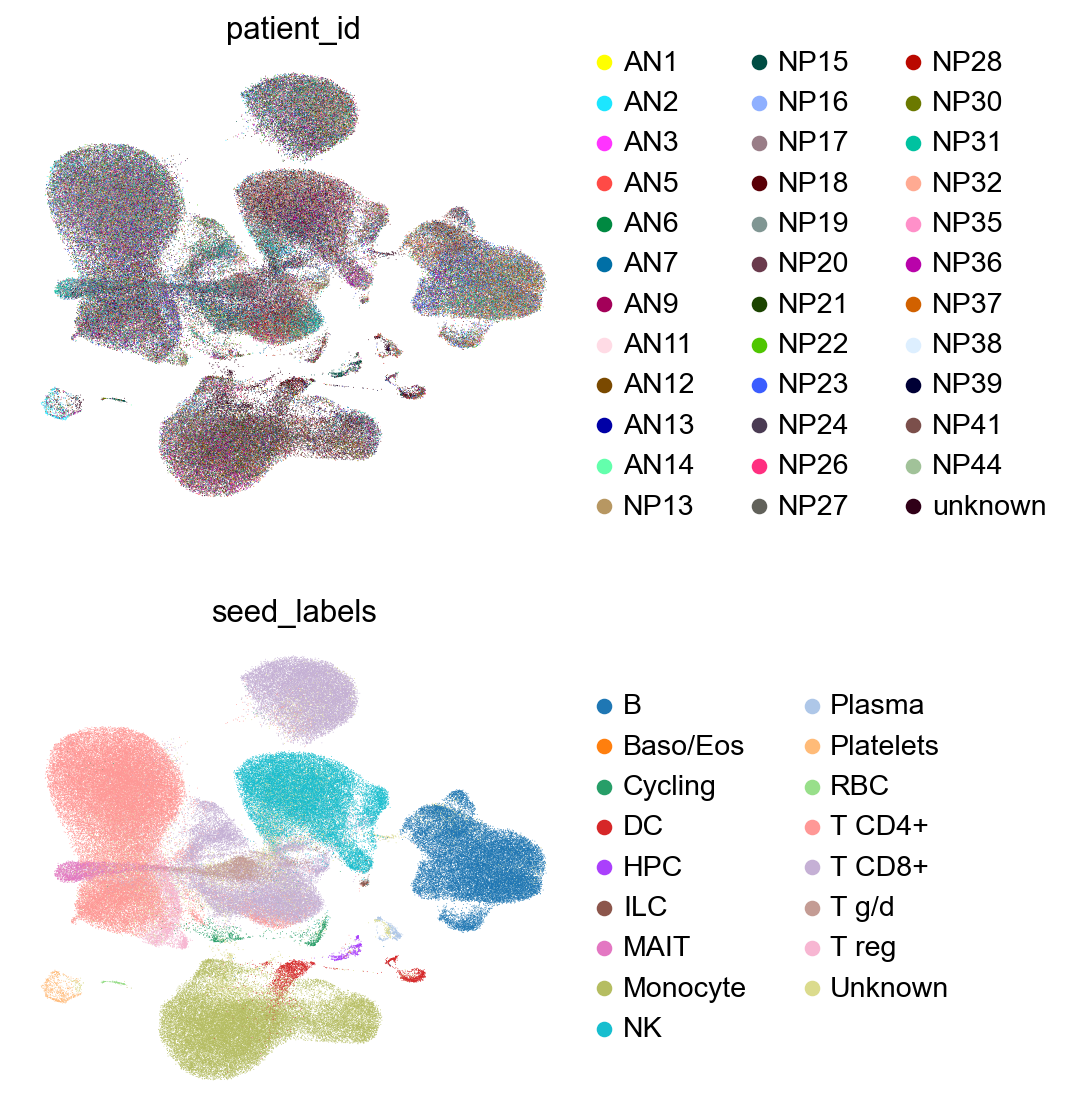

In [69]:
sc.pl.umap(
    adata_full,
    color=["patient_id", "seed_labels"],
    frameon=False,
    ncols=1,
)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


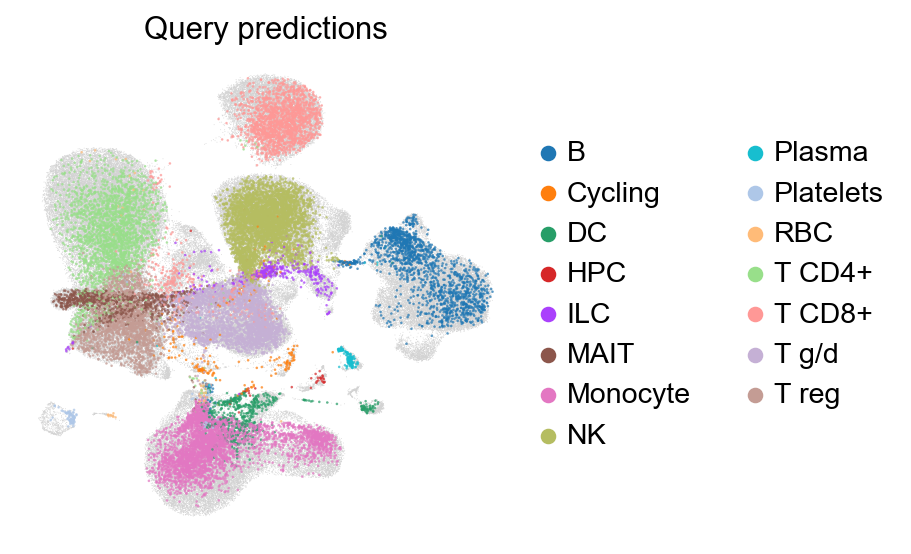

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


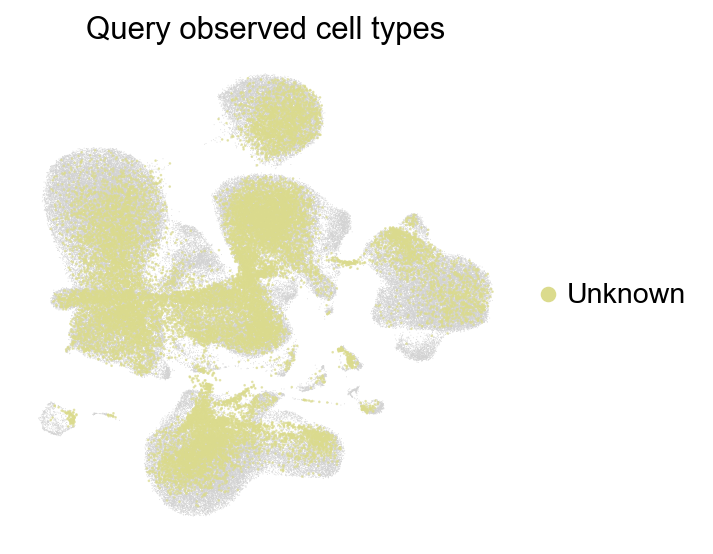

In [70]:
ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["predictions"],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["seed_labels"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)